In [1]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
import logging


def allow_soft_placement():
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    if  len(physical_devices) == 0:
        logging.warning("Not enough GPU hardware devices available")
    else:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)

allow_soft_placement()

import os
os.chdir('../src/models/')

import sys
from dotenv import load_dotenv, find_dotenv
import numpy as np
import pandas as pd
from hyperopt import space_eval
sys.path.append(os.path.abspath("../.."))
sys.path.append(os.path.abspath('../code_snippets/'))

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
# load up the entries as environment variables
load_dotenv(dotenv_path)
# import pandas as pd

import random
import matplotlib.pyplot as plt
from src.code_snippets.utils.data_handler import read_pickle,save_to_pickle
from src.code_snippets.models.many_to_one_models import InceptionTime
from src.code_snippets.models.hyperparameter_tuning import safeHyperopt,extract_trial_results
import seaborn as sns
from hyperopt import hp, space_eval
from src.code_snippets.visualization.hyperparameter_tuning import analyze_hyperparameters
from itertools import product

In [2]:
seed = 100
random.seed(seed)
np.random.seed(seed)

In [3]:
train_data = read_pickle('../../data/processed/processed_data_train.pickle')
val_data = read_pickle('../../data/processed/processed_data_val.pickle')
#test_data = read_pickle('../data/processed/processed_data_test.pickle')


In [4]:
num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
assert num_gpus_available == 1, 'GPU IS NOT AVAILABLE' 
print("Num GPUs Available: ",num_gpus_available )

AssertionError: GPU IS NOT AVAILABLE

In [5]:
trainer = InceptionTime(train_data,
                            val_data,
                            "../../data/raw/pretrained_embeddings/glove.twitter.27B/glove.twitter.27B.200d.txt")


In [6]:
trainer.set_model(
                  spatial_dropout=0.4,
                  learning_rate=0.0017436142055397088
                 )



Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

In [7]:
trainer.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 115)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 115, 200)     238703000   input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 115, 200)     0           embedding[0][0]                  
__________________________________________________________________________________________________
shortcut_conv_1 (Conv1D)        (None, 115, 128)     25728       spatial_dropout1d[0][0]          
______________________________________________________________________________________________

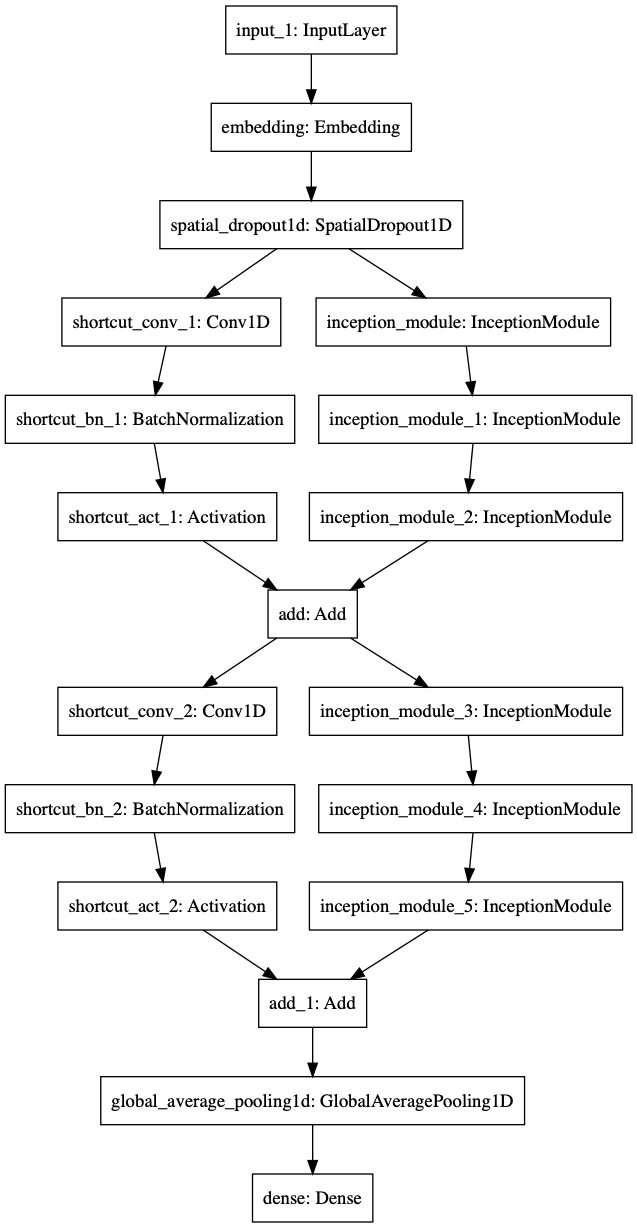

In [8]:
tf.keras.utils.plot_model(trainer.model)

In [9]:
trainer.fit_model(epochs=100,batch_size = 256)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 1/100

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:

KeyboardInterrupt: 